Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


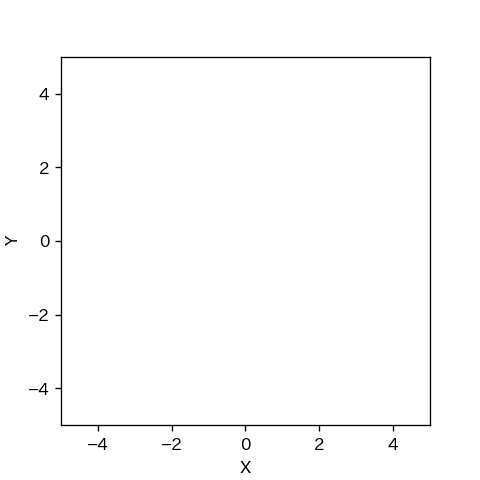

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


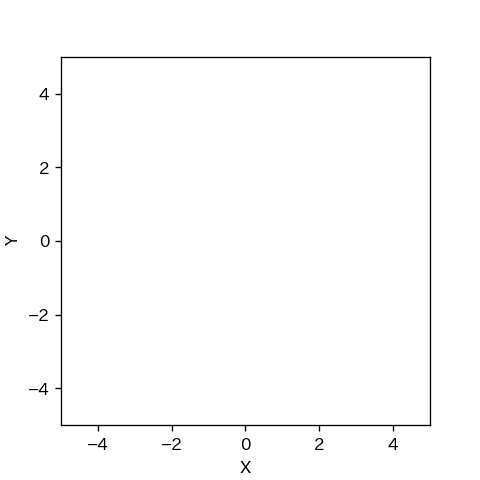

(array([1.01781448, 0.39574309, 2.12746707]),
 array([ 4.28658557, -0.7885246 , -1.78664033]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[3.7502223245562187]
0 真値: [-2.83761136 -0.68496291  3.33588344] 推定値: [-1.85983721  2.24678797 -1.47380497] 誤差: 3.0905024764286573
[2.0908172026886604]
1 真値: [ 3.71114239 -3.85352506  8.21361972] 推定値: [ 3.79150778 -4.31373614  7.96851526] 誤差: 0.46717538187567154
1
2 真値: [ 1.44729256 -1.88511376  3.00711614] 推定値: [ 1.22725405 -2.09495972  3.06332639] 誤差: 0.3040596506999278
2
[2.004056590522121]
3 真値: [4.07559033 1.37199345 7.76382585] 推定値: [4.27573877 1.27183239 7.72019416] 誤差: 0.22381161023248936
3
[2.057165417590346]
4 真値: [3.6083986  4.37505142 3.47544435] 推定値: [ 3.44192795  4.25245304 -2.81883381] 誤差: 0.20674341639775412
4
[1.7593702483559883]
5 真値: [-4.6886058  -1.81311747  6.92636931] 推定値: [-3.1161361  -1.22474493  7.33445952] 誤差: 1.6789410915812855
[2.5825056422078707]
6 真値: [1.26700512 0.72548219 5.21295435] 推定値: [1.11087235 0.44192692 5.23123767] 誤差: 0.3236989788965722
5
[4.0431745048760845, 6.730038212117213]
7 真値: [ 5.82163423 -2.13100207  2.34537399] 推定値: [ 5.81448548 -2.617

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.722904409955131]
20 真値: [ 0.76655703 -0.34018643  6.91800531] 推定値: [ 1.43934383 -0.71627493  7.0855126 ] 誤差: 0.7707688622235542
16
[4.369067680622672]
21 真値: [ 4.11823023 -1.27871057  8.79262435] 推定値: [ 4.37652203 -0.66802613  8.83000545] 誤差: 0.6630611835468981
17
[1.0614110078145436]
22 真値: [3.01054796 2.64379691 6.54868286] 推定値: [ 3.11015658  2.59132915 -0.02135561] 誤差: 0.11258216860211205
18
[2.210017746616187]
23 真値: [-2.14066703  1.90212325  7.13672295] 推定値: [-1.9705253   2.15181464  0.72742776] 誤差: 0.3021489659229674
19
[6.478528554916895]
24 真値: [-0.52143047  4.80270747  5.76492101] 推定値: [-0.94445674  4.33611506 -0.4054334 ] 誤差: 0.6298092590136255
20
[4.947067872013653]
[6.793171819629607]
25 真値: [-1.88046846 -1.05521813  3.52483242] 推定値: [-1.4124577  -1.51418426  3.70785681] 誤差: 0.6555028473477462
21
[5.6725193561055205]
26 真値: [-2.05546469 -1.77860809  7.49509924] 推定値: [-2.10578211 -3.49890242  1.03744522] 誤差: 1.7210300398057858
[3.3071966743891346]
27 真値: [4.2614228  1.830